In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(317441, 828)
(317441, 1)
validation
(36648, 828)
(36648, 1)
test
(43097, 828)
(43097, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/32 [..............................] - ETA: 47s - loss: 0.1911 - STD: 7.8497e-05 - MAE: 0.4229

 4/32 [==>...........................] - ETA: 0s - loss: 0.0688 - STD: 4.5437e-04 - MAE: 0.2005 

 5/32 [===>..........................] - ETA: 1s - loss: 0.0615 - STD: 4.0703e-04 - MAE: 0.1873

 6/32 [====>.........................] - ETA: 1s - loss: 0.0575 - STD: 3.6035e-04 - MAE: 0.1819

 7/32 [=====>........................] - ETA: 4s - loss: 0.0557 - STD: 3.2055e-04 - MAE: 0.1793

10/32 [========>.....................] - ETA: 2s - loss: 0.0511 - STD: 2.4152e-04 - MAE: 0.1748

12/32 [==========>...................] - ETA: 2s - loss: 0.0484 - STD: 2.1310e-04 - MAE: 0.1702

13/32 [===========>..................] - ETA: 2s - loss: 0.0470 - STD: 2.0354e-04 - MAE: 0.1670

14/32 [============>.................] - ETA: 1s - loss: 0.0455 - STD: 1.9622e-04 - MAE: 0.1630

15/32 [=============>................] - ETA: 1s - loss: 0.0440 - STD: 1.9065e-04 - MAE: 0.1586

16/32 [==============>...............] - ETA: 1s - loss: 0.0423 - STD: 1.8626e-04 - MAE: 0.1532

17/32 [==============>...............] - ETA: 1s - loss: 0.0407 - STD: 1.8279e-04 - MAE: 0.1478

18/32 [===============>..............] - ETA: 1s - loss: 0.0392 - STD: 1.7991e-04 - MAE: 0.1435

19/32 [================>.............] - ETA: 1s - loss: 0.0379 - STD: 1.7737e-04 - MAE: 0.1406

20/32 [=================>............] - ETA: 1s - loss: 0.0368 - STD: 1.7497e-04 - MAE: 0.1387

21/32 [==================>...........] - ETA: 1s - loss: 0.0359 - STD: 1.7270e-04 - MAE: 0.1377

22/32 [===================>..........] - ETA: 0s - loss: 0.0351 - STD: 1.7042e-04 - MAE: 0.1371

23/32 [====================>.........] - ETA: 0s - loss: 0.0345 - STD: 1.6820e-04 - MAE: 0.1367

24/32 [=====================>........] - ETA: 0s - loss: 0.0338 - STD: 1.6603e-04 - MAE: 0.1361

25/32 [======================>.......] - ETA: 0s - loss: 0.0331 - STD: 1.6396e-04 - MAE: 0.1352

26/32 [=======================>......] - ETA: 0s - loss: 0.0325 - STD: 1.6197e-04 - MAE: 0.1340

27/32 [========================>.....] - ETA: 0s - loss: 0.0318 - STD: 1.6008e-04 - MAE: 0.1325

28/32 [=========================>....] - ETA: 0s - loss: 0.0312 - STD: 1.5824e-04 - MAE: 0.1306

29/32 [==========================>...] - ETA: 0s - loss: 0.0305 - STD: 1.5650e-04 - MAE: 0.1285

30/32 [===========================>..] - ETA: 0s - loss: 0.0300 - STD: 1.5484e-04 - MAE: 0.1265

31/32 [============================>.] - ETA: 0s - loss: 0.0295 - STD: 1.5323e-04 - MAE: 0.1244

32/32 [==============================] - ETA: 0s - loss: 0.0290 - STD: 1.5170e-04 - MAE: 0.1224

32/32 [==============================] - 5s 108ms/step - loss: 0.0290 - STD: 1.5170e-04 - MAE: 0.1224 - val_loss: 0.0216 - val_STD: 9.6538e-05 - val_MAE: 0.0740


Epoch 2/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0161 - STD: 1.0607e-04 - MAE: 0.0637

 2/32 [>.............................] - ETA: 2s - loss: 0.0159 - STD: 1.0668e-04 - MAE: 0.0632

 3/32 [=>............................] - ETA: 1s - loss: 0.0157 - STD: 1.0755e-04 - MAE: 0.0627

 4/32 [==>...........................] - ETA: 1s - loss: 0.0156 - STD: 1.0878e-04 - MAE: 0.0627

 5/32 [===>..........................] - ETA: 1s - loss: 0.0155 - STD: 1.1070e-04 - MAE: 0.0629

 6/32 [====>.........................] - ETA: 1s - loss: 0.0155 - STD: 1.1280e-04 - MAE: 0.0631

 7/32 [=====>........................] - ETA: 1s - loss: 0.0154 - STD: 1.1518e-04 - MAE: 0.0637

 8/32 [======>.......................] - ETA: 1s - loss: 0.0151 - STD: 1.1753e-04 - MAE: 0.0642

 9/32 [=======>......................] - ETA: 1s - loss: 0.0150 - STD: 1.2025e-04 - MAE: 0.0654

10/32 [========>.....................] - ETA: 1s - loss: 0.0150 - STD: 1.2306e-04 - MAE: 0.0669

11/32 [=========>....................] - ETA: 1s - loss: 0.0149 - STD: 1.2583e-04 - MAE: 0.0684

13/32 [===========>..................] - ETA: 1s - loss: 0.0148 - STD: 1.3143e-04 - MAE: 0.0713

14/32 [============>.................] - ETA: 1s - loss: 0.0148 - STD: 1.3427e-04 - MAE: 0.0727

15/32 [=============>................] - ETA: 1s - loss: 0.0148 - STD: 1.3689e-04 - MAE: 0.0737

16/32 [==============>...............] - ETA: 1s - loss: 0.0147 - STD: 1.3953e-04 - MAE: 0.0745

17/32 [==============>...............] - ETA: 0s - loss: 0.0146 - STD: 1.4206e-04 - MAE: 0.0750

18/32 [===============>..............] - ETA: 0s - loss: 0.0146 - STD: 1.4454e-04 - MAE: 0.0752

19/32 [================>.............] - ETA: 0s - loss: 0.0145 - STD: 1.4701e-04 - MAE: 0.0753

20/32 [=================>............] - ETA: 0s - loss: 0.0145 - STD: 1.4936e-04 - MAE: 0.0752

21/32 [==================>...........] - ETA: 0s - loss: 0.0145 - STD: 1.5162e-04 - MAE: 0.0749

22/32 [===================>..........] - ETA: 0s - loss: 0.0144 - STD: 1.5392e-04 - MAE: 0.0747

23/32 [====================>.........] - ETA: 0s - loss: 0.0144 - STD: 1.5628e-04 - MAE: 0.0744

24/32 [=====================>........] - ETA: 0s - loss: 0.0144 - STD: 1.5863e-04 - MAE: 0.0740

25/32 [======================>.......] - ETA: 0s - loss: 0.0144 - STD: 1.6114e-04 - MAE: 0.0738

26/32 [=======================>......] - ETA: 0s - loss: 0.0144 - STD: 1.6383e-04 - MAE: 0.0737

27/32 [========================>.....] - ETA: 0s - loss: 0.0144 - STD: 1.6662e-04 - MAE: 0.0735

28/32 [=========================>....] - ETA: 0s - loss: 0.0144 - STD: 1.6955e-04 - MAE: 0.0733

29/32 [==========================>...] - ETA: 0s - loss: 0.0143 - STD: 1.7269e-04 - MAE: 0.0733

30/32 [===========================>..] - ETA: 0s - loss: 0.0143 - STD: 1.7606e-04 - MAE: 0.0733

31/32 [============================>.] - ETA: 0s - loss: 0.0143 - STD: 1.7955e-04 - MAE: 0.0733

32/32 [==============================] - ETA: 0s - loss: 0.0143 - STD: 1.8327e-04 - MAE: 0.0735

32/32 [==============================] - 2s 71ms/step - loss: 0.0143 - STD: 1.8327e-04 - MAE: 0.0735 - val_loss: 0.0189 - val_STD: 2.8525e-04 - val_MAE: 0.0904


Epoch 3/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0137 - STD: 3.1275e-04 - MAE: 0.0777

 2/32 [>.............................] - ETA: 2s - loss: 0.0136 - STD: 3.1803e-04 - MAE: 0.0782

 3/32 [=>............................] - ETA: 1s - loss: 0.0138 - STD: 3.2442e-04 - MAE: 0.0787

 4/32 [==>...........................] - ETA: 1s - loss: 0.0139 - STD: 3.3238e-04 - MAE: 0.0790

 5/32 [===>..........................] - ETA: 1s - loss: 0.0140 - STD: 3.3893e-04 - MAE: 0.0790

 6/32 [====>.........................] - ETA: 1s - loss: 0.0139 - STD: 3.4573e-04 - MAE: 0.0786

 7/32 [=====>........................] - ETA: 1s - loss: 0.0139 - STD: 3.5290e-04 - MAE: 0.0784

 8/32 [======>.......................] - ETA: 1s - loss: 0.0139 - STD: 3.5981e-04 - MAE: 0.0780

 9/32 [=======>......................] - ETA: 1s - loss: 0.0138 - STD: 3.6622e-04 - MAE: 0.0773

10/32 [========>.....................] - ETA: 1s - loss: 0.0138 - STD: 3.7374e-04 - MAE: 0.0769

12/32 [==========>...................] - ETA: 1s - loss: 0.0139 - STD: 3.8964e-04 - MAE: 0.0762

13/32 [===========>..................] - ETA: 1s - loss: 0.0139 - STD: 3.9810e-04 - MAE: 0.0758

14/32 [============>.................] - ETA: 1s - loss: 0.0139 - STD: 4.0717e-04 - MAE: 0.0755

15/32 [=============>................] - ETA: 1s - loss: 0.0139 - STD: 4.1709e-04 - MAE: 0.0753

16/32 [==============>...............] - ETA: 1s - loss: 0.0139 - STD: 4.2716e-04 - MAE: 0.0751

17/32 [==============>...............] - ETA: 0s - loss: 0.0139 - STD: 4.3828e-04 - MAE: 0.0751

18/32 [===============>..............] - ETA: 0s - loss: 0.0138 - STD: 4.4996e-04 - MAE: 0.0750

19/32 [================>.............] - ETA: 0s - loss: 0.0138 - STD: 4.6209e-04 - MAE: 0.0750

20/32 [=================>............] - ETA: 0s - loss: 0.0138 - STD: 4.7479e-04 - MAE: 0.0750

21/32 [==================>...........] - ETA: 0s - loss: 0.0138 - STD: 4.8812e-04 - MAE: 0.0751

22/32 [===================>..........] - ETA: 0s - loss: 0.0139 - STD: 5.0220e-04 - MAE: 0.0752

23/32 [====================>.........] - ETA: 0s - loss: 0.0139 - STD: 5.1717e-04 - MAE: 0.0752

24/32 [=====================>........] - ETA: 0s - loss: 0.0139 - STD: 5.3265e-04 - MAE: 0.0753

25/32 [======================>.......] - ETA: 0s - loss: 0.0139 - STD: 5.4853e-04 - MAE: 0.0753

26/32 [=======================>......] - ETA: 0s - loss: 0.0138 - STD: 5.6469e-04 - MAE: 0.0753

27/32 [========================>.....] - ETA: 0s - loss: 0.0138 - STD: 5.8164e-04 - MAE: 0.0752

28/32 [=========================>....] - ETA: 0s - loss: 0.0138 - STD: 5.9966e-04 - MAE: 0.0752

29/32 [==========================>...] - ETA: 0s - loss: 0.0138 - STD: 6.1821e-04 - MAE: 0.0751

30/32 [===========================>..] - ETA: 0s - loss: 0.0138 - STD: 6.3723e-04 - MAE: 0.0750

31/32 [============================>.] - ETA: 0s - loss: 0.0138 - STD: 6.5800e-04 - MAE: 0.0750

32/32 [==============================] - ETA: 0s - loss: 0.0138 - STD: 6.7970e-04 - MAE: 0.0749

32/32 [==============================] - 2s 72ms/step - loss: 0.0138 - STD: 6.7970e-04 - MAE: 0.0749 - val_loss: 0.0189 - val_STD: 0.0013 - val_MAE: 0.0845


Epoch 4/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0139 - STD: 0.0014 - MAE: 0.0729

 2/32 [>.............................] - ETA: 2s - loss: 0.0139 - STD: 0.0015 - MAE: 0.0731

 3/32 [=>............................] - ETA: 2s - loss: 0.0140 - STD: 0.0015 - MAE: 0.0738

 4/32 [==>...........................] - ETA: 1s - loss: 0.0138 - STD: 0.0016 - MAE: 0.0737

 5/32 [===>..........................] - ETA: 1s - loss: 0.0136 - STD: 0.0016 - MAE: 0.0734

 6/32 [====>.........................] - ETA: 1s - loss: 0.0137 - STD: 0.0017 - MAE: 0.0737

 7/32 [=====>........................] - ETA: 1s - loss: 0.0136 - STD: 0.0017 - MAE: 0.0737

 8/32 [======>.......................] - ETA: 1s - loss: 0.0137 - STD: 0.0018 - MAE: 0.0741

 9/32 [=======>......................] - ETA: 1s - loss: 0.0137 - STD: 0.0019 - MAE: 0.0742

10/32 [========>.....................] - ETA: 1s - loss: 0.0137 - STD: 0.0019 - MAE: 0.0743

11/32 [=========>....................] - ETA: 1s - loss: 0.0137 - STD: 0.0020 - MAE: 0.0743

12/32 [==========>...................] - ETA: 1s - loss: 0.0137 - STD: 0.0021 - MAE: 0.0743

13/32 [===========>..................] - ETA: 1s - loss: 0.0137 - STD: 0.0022 - MAE: 0.0743

14/32 [============>.................] - ETA: 1s - loss: 0.0136 - STD: 0.0022 - MAE: 0.0742

15/32 [=============>................] - ETA: 1s - loss: 0.0136 - STD: 0.0023 - MAE: 0.0741

16/32 [==============>...............] - ETA: 1s - loss: 0.0136 - STD: 0.0024 - MAE: 0.0740

17/32 [==============>...............] - ETA: 1s - loss: 0.0136 - STD: 0.0025 - MAE: 0.0740

18/32 [===============>..............] - ETA: 0s - loss: 0.0136 - STD: 0.0026 - MAE: 0.0739

19/32 [================>.............] - ETA: 0s - loss: 0.0136 - STD: 0.0027 - MAE: 0.0738

20/32 [=================>............] - ETA: 0s - loss: 0.0135 - STD: 0.0028 - MAE: 0.0737

21/32 [==================>...........] - ETA: 0s - loss: 0.0135 - STD: 0.0030 - MAE: 0.0736

22/32 [===================>..........] - ETA: 0s - loss: 0.0135 - STD: 0.0031 - MAE: 0.0734

23/32 [====================>.........] - ETA: 0s - loss: 0.0135 - STD: 0.0032 - MAE: 0.0734

24/32 [=====================>........] - ETA: 0s - loss: 0.0134 - STD: 0.0034 - MAE: 0.0733

25/32 [======================>.......] - ETA: 0s - loss: 0.0134 - STD: 0.0035 - MAE: 0.0732

26/32 [=======================>......] - ETA: 0s - loss: 0.0134 - STD: 0.0037 - MAE: 0.0732

27/32 [========================>.....] - ETA: 0s - loss: 0.0134 - STD: 0.0039 - MAE: 0.0731

28/32 [=========================>....] - ETA: 0s - loss: 0.0133 - STD: 0.0041 - MAE: 0.0730

29/32 [==========================>...] - ETA: 0s - loss: 0.0133 - STD: 0.0043 - MAE: 0.0729

30/32 [===========================>..] - ETA: 0s - loss: 0.0132 - STD: 0.0045 - MAE: 0.0727

32/32 [==============================] - ETA: 0s - loss: 0.0131 - STD: 0.0050 - MAE: 0.0724

32/32 [==============================] - 2s 72ms/step - loss: 0.0131 - STD: 0.0050 - MAE: 0.0724 - val_loss: 0.0164 - val_STD: 0.0120 - val_MAE: 0.0789


Epoch 5/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0118 - STD: 0.0133 - MAE: 0.0675

 2/32 [>.............................] - ETA: 2s - loss: 0.0117 - STD: 0.0139 - MAE: 0.0673

 3/32 [=>............................] - ETA: 1s - loss: 0.0118 - STD: 0.0144 - MAE: 0.0674

 4/32 [==>...........................] - ETA: 1s - loss: 0.0116 - STD: 0.0150 - MAE: 0.0669

 5/32 [===>..........................] - ETA: 1s - loss: 0.0115 - STD: 0.0156 - MAE: 0.0668

 6/32 [====>.........................] - ETA: 1s - loss: 0.0114 - STD: 0.0162 - MAE: 0.0664

 7/32 [=====>........................] - ETA: 1s - loss: 0.0114 - STD: 0.0169 - MAE: 0.0664

 8/32 [======>.......................] - ETA: 1s - loss: 0.0113 - STD: 0.0176 - MAE: 0.0662

 9/32 [=======>......................] - ETA: 1s - loss: 0.0112 - STD: 0.0183 - MAE: 0.0659

10/32 [========>.....................] - ETA: 1s - loss: 0.0110 - STD: 0.0191 - MAE: 0.0655

11/32 [=========>....................] - ETA: 1s - loss: 0.0109 - STD: 0.0198 - MAE: 0.0651

12/32 [==========>...................] - ETA: 1s - loss: 0.0108 - STD: 0.0206 - MAE: 0.0647

13/32 [===========>..................] - ETA: 1s - loss: 0.0107 - STD: 0.0214 - MAE: 0.0643

14/32 [============>.................] - ETA: 1s - loss: 0.0106 - STD: 0.0223 - MAE: 0.0639

15/32 [=============>................] - ETA: 1s - loss: 0.0104 - STD: 0.0231 - MAE: 0.0634

16/32 [==============>...............] - ETA: 1s - loss: 0.0103 - STD: 0.0241 - MAE: 0.0631

17/32 [==============>...............] - ETA: 0s - loss: 0.0102 - STD: 0.0250 - MAE: 0.0627

18/32 [===============>..............] - ETA: 0s - loss: 0.0101 - STD: 0.0261 - MAE: 0.0622

19/32 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 0.0271 - MAE: 0.0618

20/32 [=================>............] - ETA: 0s - loss: 0.0098 - STD: 0.0281 - MAE: 0.0613

21/32 [==================>...........] - ETA: 0s - loss: 0.0097 - STD: 0.0292 - MAE: 0.0608

22/32 [===================>..........] - ETA: 0s - loss: 0.0095 - STD: 0.0303 - MAE: 0.0603

23/32 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0314 - MAE: 0.0599

25/32 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.0338 - MAE: 0.0589

26/32 [=======================>......] - ETA: 0s - loss: 0.0090 - STD: 0.0349 - MAE: 0.0583

27/32 [========================>.....] - ETA: 0s - loss: 0.0089 - STD: 0.0361 - MAE: 0.0578

28/32 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0373 - MAE: 0.0573

29/32 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0385 - MAE: 0.0569

30/32 [===========================>..] - ETA: 0s - loss: 0.0085 - STD: 0.0397 - MAE: 0.0564

31/32 [============================>.] - ETA: 0s - loss: 0.0084 - STD: 0.0409 - MAE: 0.0559

32/32 [==============================] - ETA: 0s - loss: 0.0082 - STD: 0.0422 - MAE: 0.0555

32/32 [==============================] - 2s 69ms/step - loss: 0.0082 - STD: 0.0422 - MAE: 0.0555 - val_loss: 0.0059 - val_STD: 0.0751 - val_MAE: 0.0477


Epoch 6/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0825 - MAE: 0.0406

 2/32 [>.............................] - ETA: 2s - loss: 0.0043 - STD: 0.0838 - MAE: 0.0404

 4/32 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0852 - MAE: 0.0402

 5/32 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0862 - MAE: 0.0400

 6/32 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0870 - MAE: 0.0397

 7/32 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0879 - MAE: 0.0395

 8/32 [======>.......................] - ETA: 1s - loss: 0.0040 - STD: 0.0884 - MAE: 0.0393

 9/32 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0891 - MAE: 0.0391

10/32 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0898 - MAE: 0.0390

11/32 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0902 - MAE: 0.0388

12/32 [==========>...................] - ETA: 1s - loss: 0.0038 - STD: 0.0907 - MAE: 0.0386

13/32 [===========>..................] - ETA: 1s - loss: 0.0038 - STD: 0.0913 - MAE: 0.0384

14/32 [============>.................] - ETA: 1s - loss: 0.0038 - STD: 0.0917 - MAE: 0.0383

15/32 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0923 - MAE: 0.0381

16/32 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0927 - MAE: 0.0380

17/32 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0930 - MAE: 0.0379

18/32 [===============>..............] - ETA: 0s - loss: 0.0037 - STD: 0.0936 - MAE: 0.0378

19/32 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0939 - MAE: 0.0377

20/32 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0941 - MAE: 0.0376

21/32 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0944 - MAE: 0.0375

22/32 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0947 - MAE: 0.0374

23/32 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0952 - MAE: 0.0373

24/32 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0955 - MAE: 0.0372

25/32 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0957 - MAE: 0.0371

26/32 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0957 - MAE: 0.0370

27/32 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0958 - MAE: 0.0369

28/32 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0961 - MAE: 0.0368

29/32 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0965 - MAE: 0.0367

30/32 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0968 - MAE: 0.0366

31/32 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0970 - MAE: 0.0366

32/32 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0970 - MAE: 0.0365

32/32 [==============================] - 2s 71ms/step - loss: 0.0034 - STD: 0.0970 - MAE: 0.0365 - val_loss: 0.0036 - val_STD: 0.0969 - val_MAE: 0.0386


Epoch 7/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0028 - STD: 0.1020 - MAE: 0.0337

 2/32 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.1031 - MAE: 0.0336

 3/32 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0337

 4/32 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.1044 - MAE: 0.0339

 5/32 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.1040 - MAE: 0.0338

 6/32 [====>.........................] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0338

 7/32 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.1041 - MAE: 0.0338

 9/32 [=======>......................] - ETA: 1s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0337

10/32 [========>.....................] - ETA: 1s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0337

11/32 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.1040 - MAE: 0.0336

12/32 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.1039 - MAE: 0.0335

13/32 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.1037 - MAE: 0.0335

14/32 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.1038 - MAE: 0.0334

15/32 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0334

16/32 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0334

17/32 [==============>...............] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0333

18/32 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0332

19/32 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0331

20/32 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0331

21/32 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0330

22/32 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0330

23/32 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1043 - MAE: 0.0329

24/32 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1044 - MAE: 0.0328

25/32 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1046 - MAE: 0.0328

26/32 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0327

27/32 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0327

28/32 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0327

29/32 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0326

30/32 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0326

31/32 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0326

32/32 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1045 - MAE: 0.0325

32/32 [==============================] - 2s 66ms/step - loss: 0.0025 - STD: 0.1045 - MAE: 0.0325 - val_loss: 0.0025 - val_STD: 0.1012 - val_MAE: 0.0339


Epoch 8/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1068 - MAE: 0.0316

 2/32 [>.............................] - ETA: 1s - loss: 0.0022 - STD: 0.1076 - MAE: 0.0312

 3/32 [=>............................] - ETA: 1s - loss: 0.0022 - STD: 0.1072 - MAE: 0.0311

 4/32 [==>...........................] - ETA: 1s - loss: 0.0022 - STD: 0.1057 - MAE: 0.0310

 5/32 [===>..........................] - ETA: 1s - loss: 0.0022 - STD: 0.1056 - MAE: 0.0310

 6/32 [====>.........................] - ETA: 1s - loss: 0.0022 - STD: 0.1055 - MAE: 0.0310

 7/32 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.1053 - MAE: 0.0310

 8/32 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.1046 - MAE: 0.0309

 9/32 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.1047 - MAE: 0.0309

10/32 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1052 - MAE: 0.0309

11/32 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1056 - MAE: 0.0308

12/32 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.1058 - MAE: 0.0308

13/32 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.1058 - MAE: 0.0308

15/32 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.1064 - MAE: 0.0307

16/32 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1065 - MAE: 0.0306

17/32 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1064 - MAE: 0.0306

18/32 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.1066 - MAE: 0.0306

19/32 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0305

20/32 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0305

21/32 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0305

22/32 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0304

23/32 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0304

24/32 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0303

25/32 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0303

26/32 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0303

27/32 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0302

28/32 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.1068 - MAE: 0.0302

29/32 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.1067 - MAE: 0.0302

30/32 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.1066 - MAE: 0.0301

31/32 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1066 - MAE: 0.0301

32/32 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.1065 - MAE: 0.0301

32/32 [==============================] - 2s 63ms/step - loss: 0.0020 - STD: 0.1065 - MAE: 0.0301 - val_loss: 0.0019 - val_STD: 0.1034 - val_MAE: 0.0304


Epoch 9/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.1046 - MAE: 0.0291

 2/32 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1069 - MAE: 0.0293

 3/32 [=>............................] - ETA: 1s - loss: 0.0019 - STD: 0.1065 - MAE: 0.0292

 4/32 [==>...........................] - ETA: 1s - loss: 0.0019 - STD: 0.1066 - MAE: 0.0291

 5/32 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1068 - MAE: 0.0290

 6/32 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0290

 7/32 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.1074 - MAE: 0.0290

 8/32 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.1072 - MAE: 0.0290

10/32 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0289

11/32 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0288

12/32 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0288

13/32 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0288

14/32 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0288

15/32 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1074 - MAE: 0.0287

16/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1073 - MAE: 0.0287

17/32 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0287

18/32 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0287

19/32 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1075 - MAE: 0.0287

20/32 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0287

21/32 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1076 - MAE: 0.0287

22/32 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1078 - MAE: 0.0287

23/32 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1079 - MAE: 0.0287

24/32 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1079 - MAE: 0.0286

25/32 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.1079 - MAE: 0.0286

26/32 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1081 - MAE: 0.0286

27/32 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1080 - MAE: 0.0286

28/32 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1082 - MAE: 0.0285

29/32 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1083 - MAE: 0.0285

30/32 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1084 - MAE: 0.0285

31/32 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1083 - MAE: 0.0285

32/32 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1085 - MAE: 0.0285

32/32 [==============================] - 2s 63ms/step - loss: 0.0018 - STD: 0.1085 - MAE: 0.0285 - val_loss: 0.0018 - val_STD: 0.1083 - val_MAE: 0.0300


Epoch 10/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1091 - MAE: 0.0279

 2/32 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1072 - MAE: 0.0282

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1090 - MAE: 0.0280

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1084 - MAE: 0.0280

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1079 - MAE: 0.0281

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1092 - MAE: 0.0282

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0282

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0282

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0282

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0281

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0281

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0281

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1090 - MAE: 0.0280

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1091 - MAE: 0.0280

15/32 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0280

16/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0280

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0279

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0279

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0279

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0279

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0279

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0278

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0278

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0278

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1096 - MAE: 0.0278

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0277

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0277

29/32 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1095 - MAE: 0.0277

30/32 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0277

31/32 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1094 - MAE: 0.0278

32/32 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1093 - MAE: 0.0277

32/32 [==============================] - 2s 61ms/step - loss: 0.0017 - STD: 0.1093 - MAE: 0.0277 - val_loss: 0.0022 - val_STD: 0.1143 - val_MAE: 0.0325


Epoch 11/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.1132 - MAE: 0.0278

 2/32 [>.............................] - ETA: 1s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0282

 3/32 [=>............................] - ETA: 1s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0280

 4/32 [==>...........................] - ETA: 1s - loss: 0.0017 - STD: 0.1124 - MAE: 0.0282

 5/32 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0284

 6/32 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.1111 - MAE: 0.0282

 7/32 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.1115 - MAE: 0.0283

 8/32 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1108 - MAE: 0.0282

 9/32 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0282

10/32 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1105 - MAE: 0.0282

11/32 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0281

12/32 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1097 - MAE: 0.0281

13/32 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0280

14/32 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1101 - MAE: 0.0280

16/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0279

17/32 [==============>...............] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0279

18/32 [===============>..............] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0278

19/32 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.1102 - MAE: 0.0278

20/32 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0278

21/32 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0277

22/32 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0277

23/32 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0277

24/32 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0276

25/32 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1098 - MAE: 0.0276

26/32 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0276

27/32 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1099 - MAE: 0.0276

28/32 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1100 - MAE: 0.0275

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0275

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0275

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0275

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0275

32/32 [==============================] - 2s 63ms/step - loss: 0.0016 - STD: 0.1101 - MAE: 0.0275 - val_loss: 0.0016 - val_STD: 0.1091 - val_MAE: 0.0282


Epoch 12/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1041 - MAE: 0.0267

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0266

 3/32 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1081 - MAE: 0.0268

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1090 - MAE: 0.0267

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1085 - MAE: 0.0268

 7/32 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0269

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0269

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1089 - MAE: 0.0268

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1094 - MAE: 0.0269

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1094 - MAE: 0.0269

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1097 - MAE: 0.0269

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0269

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1099 - MAE: 0.0270

15/32 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0270

16/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0270

17/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0270

18/32 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0270

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0269

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0269

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0269

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1100 - MAE: 0.0270

23/32 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1101 - MAE: 0.0269

24/32 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1102 - MAE: 0.0269

25/32 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0269

26/32 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0269

27/32 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0269

28/32 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1105 - MAE: 0.0269

29/32 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0269

30/32 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1104 - MAE: 0.0269

31/32 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0269

32/32 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1103 - MAE: 0.0268

32/32 [==============================] - 2s 61ms/step - loss: 0.0016 - STD: 0.1103 - MAE: 0.0268 - val_loss: 0.0017 - val_STD: 0.1127 - val_MAE: 0.0292


Epoch 13/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0266

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1123 - MAE: 0.0267

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0267

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1118 - MAE: 0.0267

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1114 - MAE: 0.0267

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0266

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0265

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0265

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0265

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0265

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0266

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0266

15/32 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0266

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0266

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0266

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0266

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0266

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0266

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0266

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0265

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

32/32 [==============================] - 2s 63ms/step - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.1108 - val_MAE: 0.0282


Epoch 14/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0257

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1094 - MAE: 0.0262

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1101 - MAE: 0.0264

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0263

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0263

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0265

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0265

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0265

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0265

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0265

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0264

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1100 - MAE: 0.0265

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1102 - MAE: 0.0264

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1102 - MAE: 0.0264

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1102 - MAE: 0.0264

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0264

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0264

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0264

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0264

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1103 - MAE: 0.0264

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0264

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0264

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0264

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0264

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1104 - MAE: 0.0264

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0265

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0265

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0265

32/32 [==============================] - 2s 63ms/step - loss: 0.0015 - STD: 0.1107 - MAE: 0.0265 - val_loss: 0.0020 - val_STD: 0.1152 - val_MAE: 0.0314


Epoch 15/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.1150 - MAE: 0.0275

 2/32 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1106 - MAE: 0.0272

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0268

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0266

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0265

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0265

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0265

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1105 - MAE: 0.0265

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0265

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0265

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0264

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0264

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

20/32 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0263

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0263

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0263

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0263

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0264

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1107 - MAE: 0.0264

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0264

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0265

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0265

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1108 - MAE: 0.0265

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0265

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0266

32/32 [==============================] - 2s 64ms/step - loss: 0.0015 - STD: 0.1109 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.1142 - val_MAE: 0.0307


Epoch 16/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1143 - MAE: 0.0267

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1139 - MAE: 0.0266

 3/32 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0269

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1124 - MAE: 0.0268

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1124 - MAE: 0.0267

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0267

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1122 - MAE: 0.0266

 8/32 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1121 - MAE: 0.0265

 9/32 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1118 - MAE: 0.0265

10/32 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0265

11/32 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1116 - MAE: 0.0264

12/32 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0264

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1117 - MAE: 0.0264

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0265

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0264

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0264

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0264

18/32 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0264

19/32 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0264

21/32 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0264

22/32 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0264

23/32 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0264

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0263

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0264

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0264

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1109 - MAE: 0.0263

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0263

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0263

32/32 [==============================] - 2s 62ms/step - loss: 0.0015 - STD: 0.1110 - MAE: 0.0263 - val_loss: 0.0016 - val_STD: 0.1131 - val_MAE: 0.0282


Epoch 17/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0257

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1142 - MAE: 0.0257

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1130 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1123 - MAE: 0.0260

 5/32 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0260

 6/32 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0259

 7/32 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0259

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1108 - MAE: 0.0259

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0260

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

15/32 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0260

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0260

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0260

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259

32/32 [==============================] - 2s 63ms/step - loss: 0.0014 - STD: 0.1113 - MAE: 0.0259 - val_loss: 0.0015 - val_STD: 0.1124 - val_MAE: 0.0280


Epoch 18/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0256

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1105 - MAE: 0.0256

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1101 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1098 - MAE: 0.0258

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1100 - MAE: 0.0258

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1104 - MAE: 0.0258

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0258

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0258

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0258

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1107 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1104 - MAE: 0.0260

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0260

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0260

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0260

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0259

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0259

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0259

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0259

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0259

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0258

32/32 [==============================] - 2s 62ms/step - loss: 0.0014 - STD: 0.1112 - MAE: 0.0258 - val_loss: 0.0016 - val_STD: 0.1134 - val_MAE: 0.0287


Epoch 19/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0258

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0257

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0258

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0259

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0259

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0260

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0260

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0261

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0261

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0260

32/32 [==============================] - 2s 65ms/step - loss: 0.0014 - STD: 0.1113 - MAE: 0.0260 - val_loss: 0.0017 - val_STD: 0.1143 - val_MAE: 0.0295


Epoch 20/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1108 - MAE: 0.0258

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1098 - MAE: 0.0259

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0258

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0258

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0257

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0256

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0256

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0256

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0257

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0257

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0256

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0256

15/32 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0256

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0256

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0256

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0256

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0256

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0256

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1108 - MAE: 0.0258

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0258

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0258

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0258

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258

32/32 [==============================] - 2s 62ms/step - loss: 0.0014 - STD: 0.1114 - MAE: 0.0258 - val_loss: 0.0017 - val_STD: 0.1152 - val_MAE: 0.0295


Epoch 21/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1150 - MAE: 0.0261

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0259

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0259

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0259

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0259

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0259

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0260

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0260

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0260

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0260

13/32 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1122 - MAE: 0.0262

14/32 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1123 - MAE: 0.0262

15/32 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0261

16/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1119 - MAE: 0.0261

17/32 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1120 - MAE: 0.0261

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0260

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0260

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0260

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0260

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0259

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0259

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0260

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0259

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0261

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1115 - MAE: 0.0262

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0261

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1114 - MAE: 0.0263

32/32 [==============================] - 2s 62ms/step - loss: 0.0015 - STD: 0.1114 - MAE: 0.0263 - val_loss: 0.0016 - val_STD: 0.1135 - val_MAE: 0.0284


Epoch 22/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0253

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1142 - MAE: 0.0264

 3/32 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1107 - MAE: 0.0277

 4/32 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1121 - MAE: 0.0273

 5/32 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1130 - MAE: 0.0275

 6/32 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1122 - MAE: 0.0276

 7/32 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1118 - MAE: 0.0273

 8/32 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1129 - MAE: 0.0275

 9/32 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1118 - MAE: 0.0275

10/32 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1114 - MAE: 0.0274

11/32 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1121 - MAE: 0.0277

12/32 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1116 - MAE: 0.0277

13/32 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1114 - MAE: 0.0276

14/32 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1117 - MAE: 0.0276

15/32 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1117 - MAE: 0.0275

16/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1113 - MAE: 0.0275

17/32 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1115 - MAE: 0.0274

18/32 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1118 - MAE: 0.0274

19/32 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1115 - MAE: 0.0274

20/32 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1112 - MAE: 0.0273

21/32 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1114 - MAE: 0.0273

22/32 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1113 - MAE: 0.0272

24/32 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0271

25/32 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0270

26/32 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0270

27/32 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1111 - MAE: 0.0270

28/32 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0269

29/32 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0269

30/32 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

31/32 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1112 - MAE: 0.0268

32/32 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268

32/32 [==============================] - 2s 62ms/step - loss: 0.0015 - STD: 0.1113 - MAE: 0.0268 - val_loss: 0.0014 - val_STD: 0.1117 - val_MAE: 0.0272


Epoch 23/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0250

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0255

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0255

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0255

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0255

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0255

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0255

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0255

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0254

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0254

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0255

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0255

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0255

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0255

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0255

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0255

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0255

32/32 [==============================] - 2s 68ms/step - loss: 0.0014 - STD: 0.1115 - MAE: 0.0255 - val_loss: 0.0015 - val_STD: 0.1124 - val_MAE: 0.0276


Epoch 24/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1074 - MAE: 0.0250

 2/32 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1098 - MAE: 0.0250

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1100 - MAE: 0.0251

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1105 - MAE: 0.0252

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1105 - MAE: 0.0252

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1109 - MAE: 0.0253

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0254

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0254

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0254

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0255

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0254

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0254

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

15/32 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0254

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

32/32 [==============================] - 2s 60ms/step - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254 - val_loss: 0.0015 - val_STD: 0.1125 - val_MAE: 0.0279


Epoch 25/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1091 - MAE: 0.0251

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0253

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0254

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1124 - MAE: 0.0254

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1128 - MAE: 0.0254

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1124 - MAE: 0.0254

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0254

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0255

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0256

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0256

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0256

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0256

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0257

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257

32/32 [==============================] - 2s 65ms/step - loss: 0.0014 - STD: 0.1117 - MAE: 0.0257 - val_loss: 0.0015 - val_STD: 0.1125 - val_MAE: 0.0274


Epoch 26/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0250

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1105 - MAE: 0.0255

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0255

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0256

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1127 - MAE: 0.0255

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1129 - MAE: 0.0255

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0254

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0253

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0253

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0253

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

32/32 [==============================] - 2s 64ms/step - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253 - val_loss: 0.0014 - val_STD: 0.1118 - val_MAE: 0.0269


Epoch 27/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1109 - MAE: 0.0253

 2/32 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1112 - MAE: 0.0250

 3/32 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1114 - MAE: 0.0250

 4/32 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1116 - MAE: 0.0251

 5/32 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1115 - MAE: 0.0252

 6/32 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1115 - MAE: 0.0252

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0252

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0252

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0252

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0253

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0253

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0253

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

32/32 [==============================] - 2s 66ms/step - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253 - val_loss: 0.0014 - val_STD: 0.1121 - val_MAE: 0.0272


Epoch 28/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1114 - MAE: 0.0250

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1103 - MAE: 0.0252

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0253

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1106 - MAE: 0.0254

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1110 - MAE: 0.0253

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0252

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0252

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0252

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0253

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0253

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

32/32 [==============================] - 2s 64ms/step - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254 - val_loss: 0.0014 - val_STD: 0.1133 - val_MAE: 0.0271


Epoch 29/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1120 - MAE: 0.0248

 2/32 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1134 - MAE: 0.0251

 3/32 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1129 - MAE: 0.0251

 4/32 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1124 - MAE: 0.0251

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0252

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1112 - MAE: 0.0254

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0254

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0253

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0253

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0253

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0254

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0254

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0255

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0254

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0255

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

32/32 [==============================] - 2s 66ms/step - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255 - val_loss: 0.0016 - val_STD: 0.1159 - val_MAE: 0.0284


Epoch 30/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1136 - MAE: 0.0251

 2/32 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1149 - MAE: 0.0253

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0259

 4/32 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1128 - MAE: 0.0262

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0261

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0259

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0259

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0259

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0258

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1128 - MAE: 0.0257

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1124 - MAE: 0.0258

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0258

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0257

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0257

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0257

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0256

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0256

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1115 - MAE: 0.0256

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0256

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0256

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0256

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0256

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0255

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0255

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0255

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0255

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0255

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0255

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

32/32 [==============================] - 2s 65ms/step - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.1163 - val_MAE: 0.0307


Epoch 31/10000


 1/32 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1175 - MAE: 0.0264

 2/32 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1129 - MAE: 0.0260

 3/32 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1129 - MAE: 0.0255

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1132 - MAE: 0.0255

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1130 - MAE: 0.0255

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1132 - MAE: 0.0254

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1132 - MAE: 0.0255

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1126 - MAE: 0.0257

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1131 - MAE: 0.0258

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0258

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0257

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0257

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0257

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0257

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0257

16/32 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0256

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0256

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0254

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0254

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0254

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0254

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0254

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0253

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0253

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253

32/32 [==============================] - 2s 65ms/step - loss: 0.0014 - STD: 0.1119 - MAE: 0.0253 - val_loss: 0.0014 - val_STD: 0.1144 - val_MAE: 0.0270


Epoch 32/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1148 - MAE: 0.0253

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1137 - MAE: 0.0254

 4/32 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0253

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1113 - MAE: 0.0252

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0253

 7/32 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1116 - MAE: 0.0254

 8/32 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0253

 9/32 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0253

10/32 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0254

11/32 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0256

12/32 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1122 - MAE: 0.0256

13/32 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1123 - MAE: 0.0256

14/32 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0256

15/32 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0256

16/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1117 - MAE: 0.0256

17/32 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0256

18/32 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0256

19/32 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1118 - MAE: 0.0256

20/32 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1121 - MAE: 0.0255

21/32 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

22/32 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

23/32 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

24/32 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0255

25/32 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0255

26/32 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

27/32 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

28/32 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

29/32 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

30/32 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

31/32 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1120 - MAE: 0.0254

32/32 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254

32/32 [==============================] - 2s 64ms/step - loss: 0.0014 - STD: 0.1119 - MAE: 0.0254 - val_loss: 0.0016 - val_STD: 0.1157 - val_MAE: 0.0289


Epoch 33/10000


 1/32 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1149 - MAE: 0.0254

 2/32 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1138 - MAE: 0.0254

 3/32 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1129 - MAE: 0.0253

 4/32 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1131 - MAE: 0.0253

 5/32 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1125 - MAE: 0.0253

 6/32 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1128 - MAE: 0.0253

 7/32 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1131 - MAE: 0.0252

 8/32 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1128 - MAE: 0.0252

 9/32 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1131 - MAE: 0.0252

10/32 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1129 - MAE: 0.0252

11/32 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1128 - MAE: 0.0251

12/32 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1127 - MAE: 0.0251

13/32 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1125 - MAE: 0.0251

14/32 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1124 - MAE: 0.0251

15/32 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1123 - MAE: 0.0251

16/32 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1125 - MAE: 0.0251

17/32 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1123 - MAE: 0.0251

18/32 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1124 - MAE: 0.0251

19/32 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1125 - MAE: 0.0251

20/32 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1126 - MAE: 0.0251

22/32 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1126 - MAE: 0.0250

23/32 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1125 - MAE: 0.0250

24/32 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1123 - MAE: 0.0251

25/32 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1123 - MAE: 0.0251

26/32 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1123 - MAE: 0.0251

27/32 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1122 - MAE: 0.0251

28/32 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1123 - MAE: 0.0251

29/32 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1122 - MAE: 0.0251

30/32 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1122 - MAE: 0.0251

31/32 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1120 - MAE: 0.0251

32/32 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1120 - MAE: 0.0251

32/32 [==============================] - 2s 65ms/step - loss: 0.0013 - STD: 0.1120 - MAE: 0.0251 - val_loss: 0.0015 - val_STD: 0.1136 - val_MAE: 0.0282


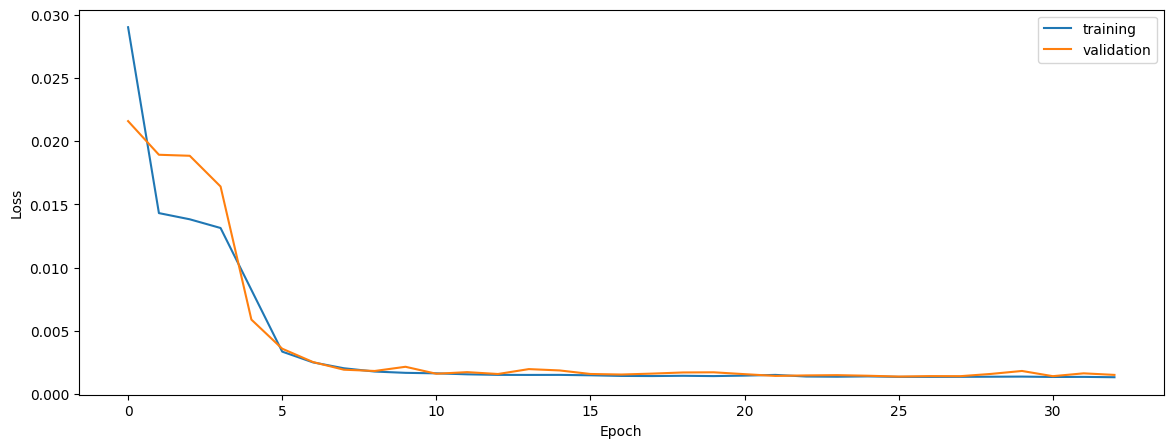

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9501469250116548
0.964137908050698
0.9471812771278479


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.9501469250116548
0.964137908050698
0.9471812771278479


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.9483733743338825
0.9614678391078773
0.9472949364263464


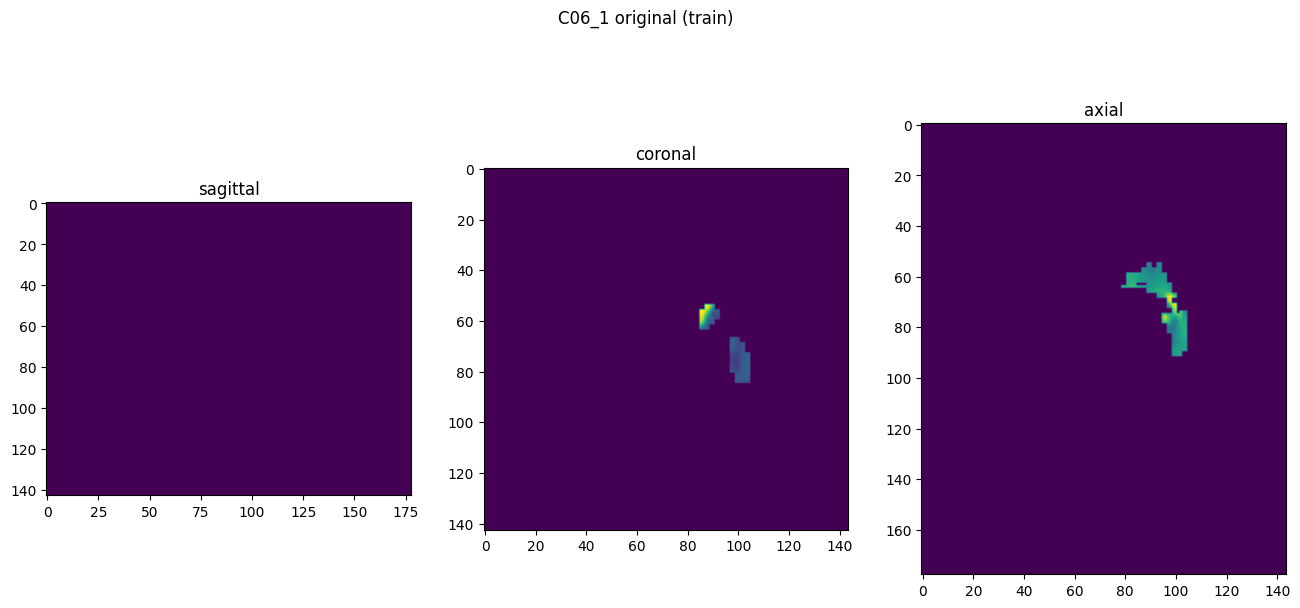

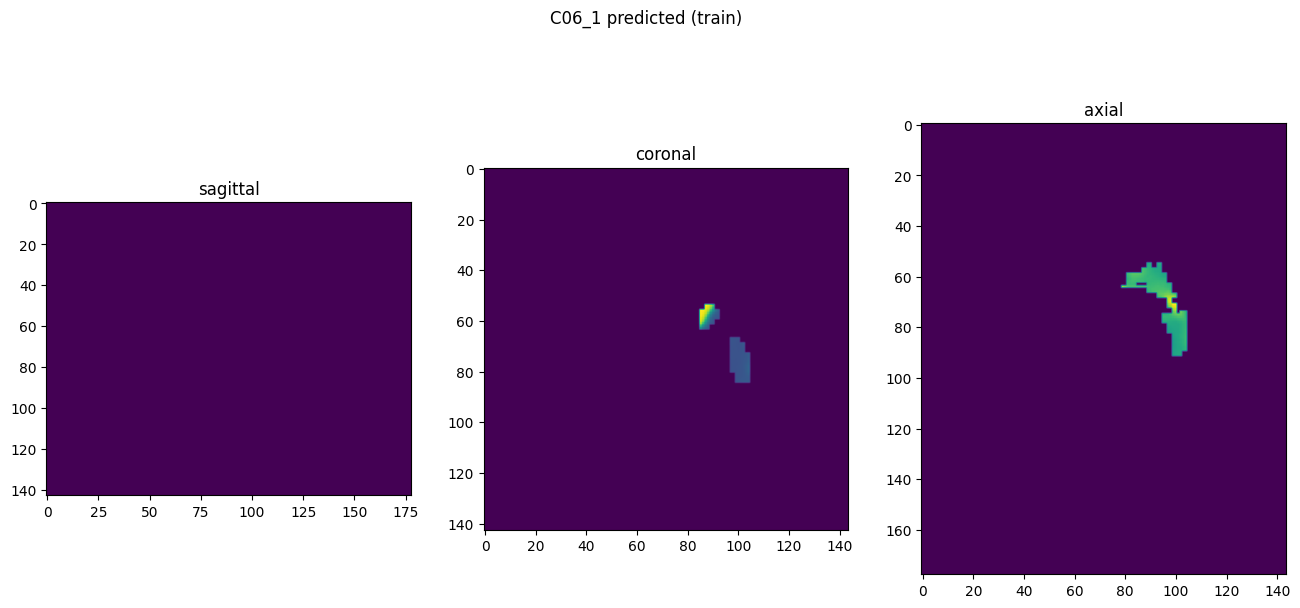

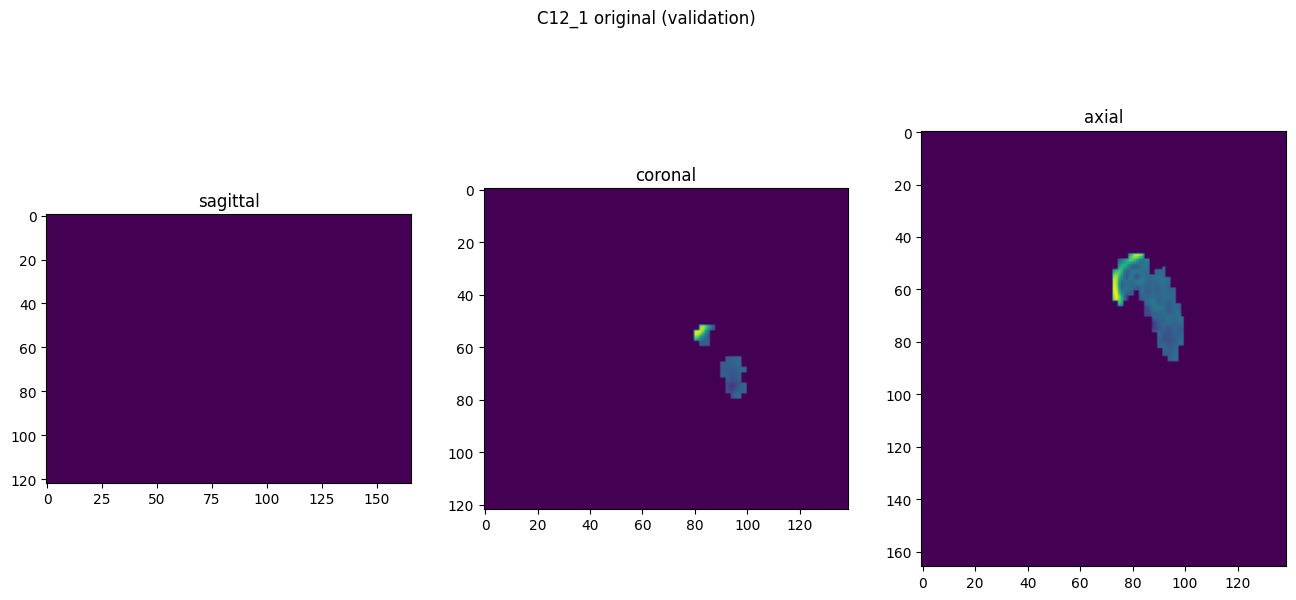

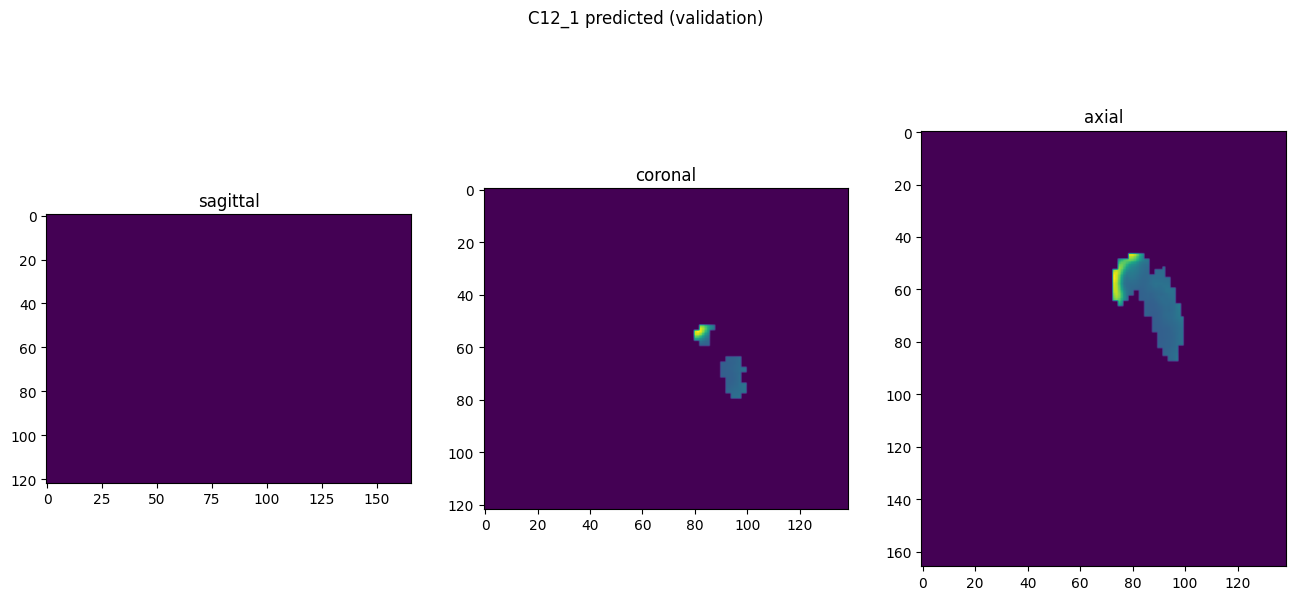

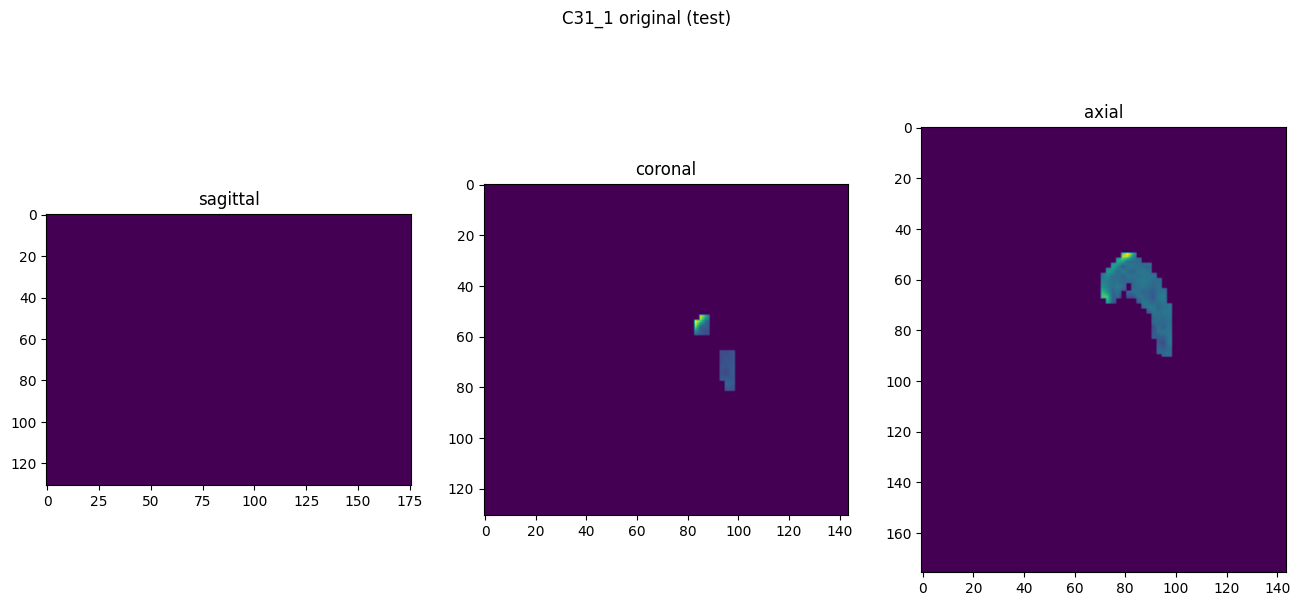

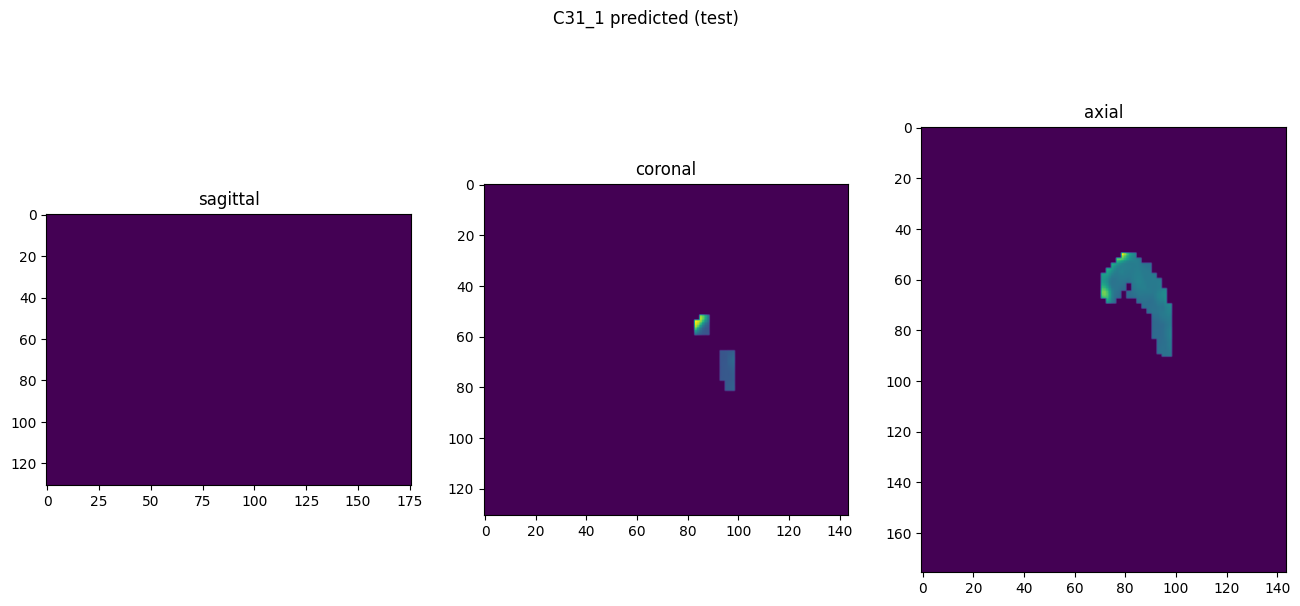

In [10]:
showResults(model, gen, threshold=None, background=False)